# To create Global Warming Increment (GWI) files from downloaded data

In [ ]:
#exps = ['historical','ssp585','ssp370','ssp245','ssp126']

In [33]:
import xarray as xr
import numpy as np
import os, glob, sys
import datetime
import pandas as pd


In [34]:
input_dir = 'Download_CMIP6/Download/'
base_dir = '/Users/doan/Google Drive/My Drive/share/2024/PGW_DS/'

In [35]:
aa  = '1990-2019_2070-2099'
g   = 'EC-Earth3'
ssp = 'ssp585'
varn = ['ts', 'ta', 'hur', 'ua', 'va', 'zg']
gwi_dir = base_dir + '/GWI/' +ssp+'/' + g + '/' + aa +'/'
if not os.path.exists(gwi_dir): os.makedirs(gwi_dir)

In [36]:
for v in varn[:]:
    tbs, tbe = aa.split('_')[0].split('-') 
    tfs, tfe = aa.split('_')[1].split('-') 
    
    hfile = glob.glob(input_dir+ '/'+g+ '/historical/'+v+'_*'+g+'*')[0]
    rfile = glob.glob(input_dir+'/'+ g + '/'+ ssp+'/'+v+'_*'+g+'*')[0]

    print(g, ssp, v)
    
    rd = xr.open_dataset(rfile)[v] 
    hd = xr.open_dataset(hfile)[v] 
        
    hr_base1 = hd.sel(time = slice( tbs ,  tbe))
    hr_base2 = rd.sel(time = slice( tbs ,  tbe))
    # datetime format
    if not type(hr_base2.time.values[0]) == np.datetime64:
        xx  = [ datetime.datetime.strptime(str(t),'%Y-%m-%d %H:%M:%S') for t in hr_base2.time.values]
        hr_base2.time.values[:] =xx
    
    hr_base = xr.concat([hr_base1, hr_base2], dim='time')
    if hr_base.time.size != ( int(tbe) - int(tbs) + 1)*12: 
        sys.exit()
        print('problem with baseline file')
    
    hr_targ = rd.sel(time = slice( tfs , tfe ))
    
    bmean = hr_base.groupby('time.month').mean('time')
    tmean = hr_targ.groupby('time.month').mean('time')
        
    diff = tmean.copy()
    diff[:] = tmean.values[:] - bmean.values[:]
    
    excluded_dims = ['month', 'lat', 'lon', 'plev']
    # Identify all the dimensions in the dataset excluding the specified ones
    dims_to_select = [dim for dim in diff.dims if dim not in excluded_dims]
    # Select the first point along each of these dimensions
    selection = {dim: 0 for dim in dims_to_select}
   
    do = diff.isel(selection)
    do.to_netcdf(gwi_dir+v+'.nc' )
              

EC-Earth3 ssp585 ts
EC-Earth3 ssp585 ta
EC-Earth3 ssp585 hur
EC-Earth3 ssp585 ua
EC-Earth3 ssp585 va
EC-Earth3 ssp585 zg


In [37]:
import pywinter.winter as pyw
import xesmf as xe

In [47]:
wrf_interfile  ='WRF_run/control/ERA5A:2023-01-01_00'
run_id = 'tok_test_dom'

In [41]:
interfile = pyw.rinter(wrf_interfile) 
x = interfile['TT']
slat, slon = x.geoinfo['STARTLAT'], x.geoinfo['STARTLON']
dlat, dlon = x.geoinfo['DELTALAT'], x.geoinfo['DELTALON']
shape = x.val.shape
lev = x.level
lat = [ slat + i*dlat for i in range(shape[-2]) ]
lon = [ slon + i*dlon for i in range(shape[-1]) ]

In [43]:
target_grid = xr.Dataset({
    'lat': (['lat'], lat),
    'lon': (['lon'], lon), 
})
new_levels = xr.DataArray(lev, dims="plev", name="plev")  

In [44]:
var_info = { 'RH': 'hur', 'TT':'ta', 'UU':'ua', 'VV':'va', 'GHT':'zg', 'SKINTEMP':'ts', 'SST':'ts' }

In [45]:
do = xr.Dataset()
for k, v in var_info.items():
    print(k, v)
    f = gwi_dir+v+'.nc'
    ds = xr.open_dataset(f)[v]   
    
    regridder = xe.Regridder(ds, target_grid, method='bilinear')
    regridded_data = regridder(ds)
    if not v in ['ts']: regridded_data = regridded_data.interp(plev=new_levels)    

    do[k] = regridded_data

RH hur
TT ta
UU ua
VV va
GHT zg
SKINTEMP ts
SST ts


In [48]:
gwi_tdom_dir = base_dir + 'GWI4TDOM/' + run_id + '/'
if not os.path.exists(gwi_tdom_dir): os.makedirs(gwi_tdom_dir)
ofile = gwi_tdom_dir + '/'+ ssp + '.' + g + '.' + aa + '.nc'
do.to_netcdf(ofile)

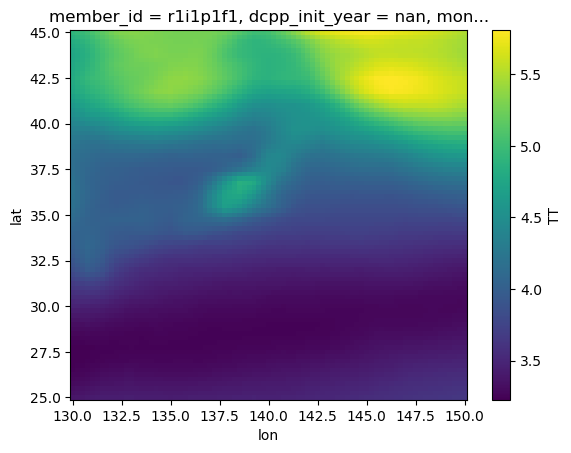

In [49]:
do.TT[0,2].plot()